# Pylops - seismic inversion

### Author: M.Ravasi

This notebook will focus on running post-stack inversion (for Acoustic Impedence) on GPUs using the Pylops-gpu framework

In [1]:
#!pip install pylops
#!pip install git+https://git@github.com/equinor/pylops.git@master
#!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import filtfilt
from scipy.sparse.linalg import cg, lsqr
from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from pylops import Diagonal, MatrixMult, FirstDerivative
from pylops.avo.poststack import PoststackLinearModelling

from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu.avo.poststack import PoststackLinearModelling as gPoststackLinearModelling
from pylops_gpu.optimization import cg as gcg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cpu...


## Post-stack inversion - 1D

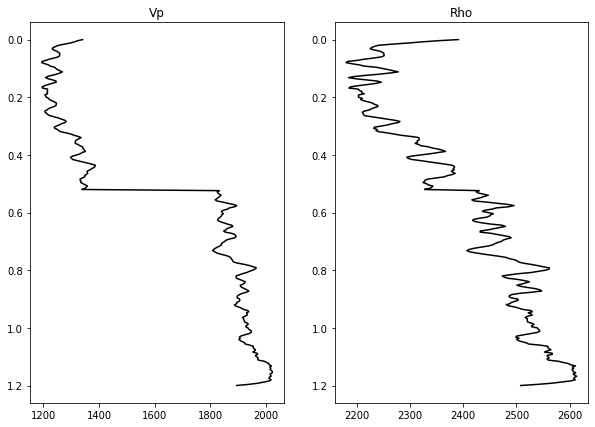

In [4]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
rho[131:]+=100

m1d = np.log(vp*rho).flatten()
m1d = torch.from_numpy(m1d.astype(np.float32)).to(dev)

fig, axs = plt.subplots (1, 2, figsize=(10, 7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()

In [5]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [6]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)).to(dev), nt0=nt0, 
                                device=dev)
gdottest(PPop, nt0, nt0, device=dev, verb=True, tol=1e-4)

# dense
PPop_dense = gPoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True, 
                                      device=dev)
#gdottest(PPop_dense, nt0, nt0, device=dev, verb=True, tol=1e-4)

# pylops
PPop_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0)
dottest(PPop_pylops, nt0, nt0, verb=True, tol=1e-4)

# pylops
PPop_dense_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True)
dottest(PPop_dense_pylops, nt0, nt0, verb=True, tol=1e-4)

# data
d = PPop * m1d
#d_dense = PPop_dense * m1d
d_pylops = PPop_pylops * m1d.cpu().numpy()
d_dense_pylops = PPop_dense_pylops * m1d.cpu().numpy()

u.shape torch.Size([301])
u.shape torch.Size([301])
Dot test passed, v^T(Opu)=-26.138182 - u^T(Op^Tv)=-26.138186
Dot test passed, v^T(Opu)=-6.815358 - u^T(Op^Tv)=-6.815358
Dot test passed, v^T(Opu)=9.496557 - u^T(Op^Tv)=9.496557


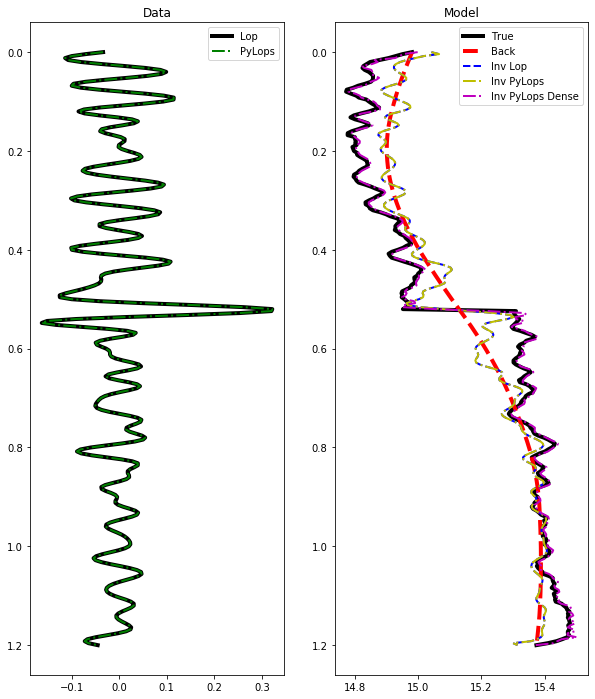

In [7]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d.cpu().numpy())
m1dback = torch.from_numpy(m1dback.astype(np.float32)).to(dev)

# solve lop
d0 = PPop * m1dback
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr, niter=10)[0]
minv = m1dback + minv

# solve pylops lop
d0_pylops = PPop_pylops * m1dback.cpu().numpy()
dr_pylops = d.cpu().numpy() - d0.cpu().numpy()
minv_pylops = cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=10)[0]
minv_pylops = m1dback.cpu().numpy() + minv_pylops

# solve dense
#d0_dense = PPop*m1dback
#dr_dense = d_dense - d0_dense
#minv_dense = torch.solve(dr_dense.reshape(nt0, 1) , 
#                         PPop_dense.A.reshape(nt0, nt0) + 1e-4*torch.eye(nt0, dtype=torch.float32)).solution.flatten()
#minv_dense = m1dback + minv_dense

# solve dense pylops
d0_pylops_dense = PPop_dense_pylops*m1dback.cpu().numpy()
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense, rcond=1e-5)[0]
#minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_pylops_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = m1dback.cpu().numpy() + minv_pylops_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d.cpu().numpy(), t0, 'k', lw=4, label='Lop')
#axs[0].plot(d_dense.cpu().numpy(), t0,'--r', lw=2, label='Dense')
axs[0].plot(d_pylops, t0,'-.g', lw=2, label='PyLops')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d.cpu().numpy(), t0, 'k', lw=4, label='True')
axs[1].plot(m1dback.cpu().numpy(), t0, '--r', lw=4, label='Back')
axs[1].plot(minv.cpu().numpy(), t0, '--b', lw=2, label='Inv Lop')
#axs[1].plot(minv_dense.cpu().numpy(), t0, '--g', lw=2, label='Inv Dense')
axs[1].plot(minv_pylops, t0, '-.y', lw=2, label='Inv PyLops')
axs[1].plot(minv_pylops_dense, t0, '-.m', lw=2, label='Inv PyLops Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

In [8]:
%timeit -r 3 -n 10 cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=50)[0]
%timeit -r 3 -n 10 gcg(PPop.H * PPop, PPop.H * dr, niter=50)[0]

65.4 ms ± 8.12 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
69.3 ms ± 19.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


## Post-stack inversion - 2D

In [9]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

m = torch.from_numpy(m.astype(np.float32)).to(dev)

Create operators

In [10]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)).to(dev),
                                 nt0=nz, spatdims=nx, explicit=False,
                                 device=dev)
gdottest(PPop, nz*nx, nz*nx, device=dev, verb=True, tol=1e-3)

# dense
PPop_dense = gPoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
gdottest(PPop_dense, nz*nx, nz*nx, device=dev, verb=True, tol=1e-3)

# lop
PPop_pylops = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop_pylops, nz*nx, nz*nx, verb=True, tol=1e-3)

# dense
PPop_dense_pylops = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop_dense_pylops, nz*nx, nz*nx, verb=True, tol=1e-3)


# data
d = (PPop * m.flatten()).reshape(nz, nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)
d_pylops = (PPop_pylops * m.cpu().numpy().flatten()).reshape(nz,nx)
d_dense_pylops = (PPop_dense_pylops * m.cpu().numpy().flatten()).reshape(nz,nx)

u.shape torch.Size([440000])
u.shape torch.Size([440000])
Dot test passed, v^T(Opu)=-598.688721 - u^T(Op^Tv)=-598.688965
u.shape torch.Size([440000])
u.shape torch.Size([440000])
Dot test passed, v^T(Opu)=-645.699341 - u^T(Op^Tv)=-645.698486
Dot test passed, v^T(Opu)=713.756415 - u^T(Op^Tv)=713.756415
Dot test passed, v^T(Opu)=-919.826089 - u^T(Op^Tv)=-919.826089


In [11]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m.cpu().numpy(), axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)
mback = torch.from_numpy(mback.astype(np.float32)).to(dev)

d0 = (PPop*mback.flatten()).reshape(nz,nx)
d0_dense = (PPop_dense*mback.flatten()).reshape(nz,nx)
d0_pylops = (PPop_pylops * mback.cpu().numpy().flatten()).reshape(nz,nx)
d0_pylops_dense = (PPop_dense_pylops*mback.cpu().numpy().flatten()).reshape(nz,nx)

In [12]:
# solve lop
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr.flatten(), niter=10)[0]
minv = mback + minv.reshape(nz,nx)

# solve pylops lop
dr_pylops = d_pylops - d0_pylops
minv_pylops = cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops.flatten(),
                 maxiter=10)[0]
minv_pylops = mback.cpu().numpy() + minv_pylops.reshape(nz,nx)

# solve dense
dr_dense = d_dense - d0_dense
minv_dense = torch.solve(dr_dense.reshape(nz, nx) , 
                         PPop_dense.A + 1e-3*torch.eye(nz, dtype=torch.float32)).solution
minv_dense = mback + minv_dense.reshape(nz,nx)

# solve dense pylops
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense)[0]
#minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = mback.cpu().numpy() + minv_pylops_dense.reshape(nz,nx)

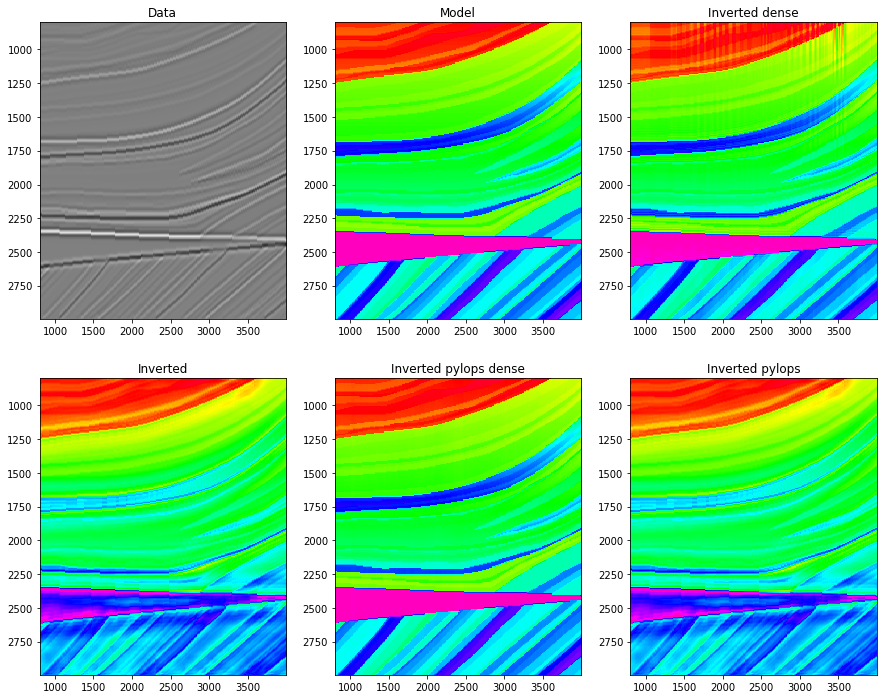

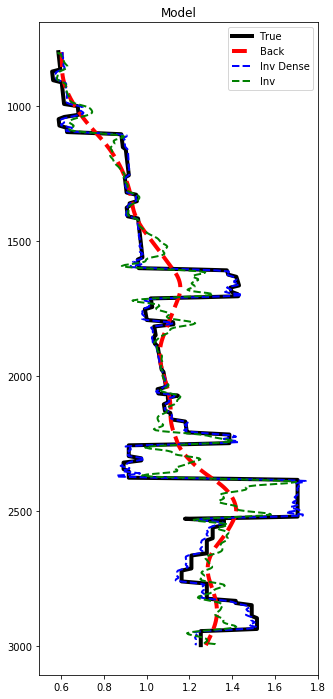

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(minv_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Inverted dense')
axs[0][2].axis('tight')
axs[1][0].imshow(minv, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight');
axs[1][1].imshow(minv_pylops_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted pylops dense')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_pylops, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted pylops')
axs[1][2].axis('tight');


fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2].cpu().numpy(), z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2].cpu().numpy(), z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2].cpu().numpy(), z, '--b', lw=2, label='Inv Dense')
ax.plot(minv[:,nx//2].cpu().numpy(), z, '--g', lw=2, label='Inv')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

In [260]:
import pytest
import torch

from pylops import MatrixMult, Diagonal
from numpy.testing import assert_array_almost_equal
from pylops_gpu.utils import dottest
from pylops_gpu.utils.backend import device
from pylops_gpu.utils.complex import *
from pylops_gpu import MatrixMult as gMatrixMult
from pylops_gpu import Diagonal as gDiagonal
from pylops_gpu.optimization.leastsquares import cg


par = {'ny': 21, 'nx': 11, 'nt': 20, 'imag': 1j,
       'dtype': 'float32'}  # complex

dev = device()
np.random.seed(0)
torch.manual_seed(0)

d = (np.arange(0, par['nx'], dtype=par['dtype']) + 1.) + \
    par['imag'] * (np.arange(0, par['nx'], dtype=par['dtype']) + 1.)

Dop = Diagonal(d)
gDop = gDiagonal(d, dtype=d.dtype)

assert dottest(gDop, par['nx'], par['nx'], tol=1e-4,
               complexflag=0 if par['imag'] == 0 else 3)

u.shape torch.Size([1, 11])


In [261]:
x = (np.ones(par['nx'], dtype=par['dtype'])).flatten() + \
        (par['imag'] * np.ones(par['nx'], dtype=par['dtype'])).flatten()
xg = complextorch_fromnumpy(x).to(dev)  

In [262]:
complexnumpy_fromtorch(gDop.matvec(xg)) - Dop * x

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j], dtype=complex64)

In [263]:
complexnumpy_fromtorch(gDop.rmatvec(xg)) - Dop.H * x

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j], dtype=complex64)

In [280]:
xgcg = gcg(gDop, gDop * xg, niter=10)[0]
xgcg

<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>
<class 'complex'>


tensor([0.9999188 +0.9999188j , 1.0002029 +1.0002029j ,
       0.9995941 +0.9995941j , 1.0006089 +1.0006089j ,
       0.999318  +0.999318j  , 1.0005683 +1.0005683j ,
       0.999652  +0.999652j  , 1.0001522 +1.0001522j ,
       0.9999548 +0.9999548j , 1.000008  +1.000008j  ,
       0.99999917+0.99999917j], dtype=complex64)

In [270]:
def conjgrad(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A._matvec(x)
    #print('r', r)
    d = r.copy()
    k = r.dot(r)
    print('k', k)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A._matvec(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A._matvec(d)
        dAd = np.dot(d, Ad)
        #print('Ad', Ad)
        #print('dAd', dAd)
        a = k / dAd
        #print('a', a)
        x += a*d
        r -= a*Ad
        kold = k
        k = np.dot(r, r)
        b = k / kold
        d = r + b*d;
    return x

In [271]:
xcg = conjgrad(Dop, Dop * x, np.zeros_like(x), niter=10)
xcg

k (-2024+0j)


array([0.99991894+0.99991894j, 1.0002029 +1.0002029j ,
       0.9995941 +0.9995941j , 1.0006089 +1.0006089j ,
       0.9993181 +0.9993181j , 1.0005683 +1.0005683j ,
       0.999652  +0.999652j  , 1.0001521 +1.0001521j ,
       0.9999548 +0.9999548j , 1.000008  +1.000008j  ,
       0.9999994 +0.9999994j ], dtype=complex64)

In [134]:
gDop.diag.abs()

tensor([[ 1.4142,  2.8284,  4.2426,  5.6569,  7.0711,  8.4853,  9.8995, 11.3137,
         12.7279, 14.1421, 15.5563]])

In [69]:
ComplexTensor(conj(gDop.diag) * gDop.diag.abs().pow(-2))

array([ 5.9604645e-08+1.j        ,  2.9802322e-08+0.5j       ,
        1.4901161e-08+0.33333337j,  1.4901161e-08+0.25j      ,
       -7.4505806e-09+0.19999999j,  7.4505806e-09+0.16666669j,
       -7.4505806e-09+0.14285713j,  7.4505806e-09+0.125j     ,
       -3.7252903e-09+0.1111111j , -3.7252903e-09+0.09999999j,
        0.0000000e+00+0.09090909j], dtype=complex64)

In [70]:
complexnumpy_fromtorch(ComplexTensor(conj(gDop.diag) * gDop.diag.abs().pow(-2))) - 1./ Dop.diag

array([ 5.9604645e-08+1.j        ,  2.9802322e-08+0.5j       ,
        1.4901161e-08+0.33333337j,  1.4901161e-08+0.25j      ,
       -7.4505806e-09+0.19999999j,  7.4505806e-09+0.16666669j,
       -7.4505806e-09+0.14285713j,  7.4505806e-09+0.125j     ,
       -3.7252903e-09+0.1111111j , -3.7252903e-09+0.09999999j,
        0.0000000e+00+0.09090909j], dtype=complex64)

In [139]:
from pytorch_complex_tensor import ComplexTensor, ComplexScalar

In [152]:
a = ComplexTensor([[1, 1], [1, 2]])

In [247]:
from pylops_gpu.utils.complex import complexscalar_fromtorchscalar
b=a.sum()
complexscalar_fromtorchscalar(b)

(2+3j)

In [276]:
divide(xg, gDop.diag)

array([1.        +0.j, 0.5       +0.j, 0.33333334+0.j, 0.25      +0.j,
       0.2       +0.j, 0.16666667+0.j, 0.14285715+0.j, 0.125     +0.j,
       0.11111111+0.j, 0.1       +0.j, 0.09090909+0.j], dtype=complex64)